# Homework 3: Differentiable Programming

In [1]:
import torch
import matplotlib.pyplot as plt

## 1. Edge Cases of Automatic Differentiation

We will construct some cases where PyTorch returns derivatives that make no sense. The underlying problem is that PyTorch does not sanitize its inputs; it relies on the users to make sure the inputs to automatic differentiation are well-defined mathematically. You might find it helpful to go over this week’s demo again to revisit the difference between a mathematical function and a DiffProg function.

**NOTE:** For each exercise in the homework, write a vanilla Python function and compute its derivative as returned by PyTorch’s automatic differentiation engine. Do not write your own `torch.autograd.Function` implementation (that would defeat the purpose of the homework).

### 1.1 Recall that if a (mathematical) function $f : \R \rightarrow \R$ is discontinuous at a point $\hat{x}$, then it cannot be differentiable at $\hat{x}$.

- Define and plot a (mathematical) function $f : \R \rightarrow \R$ which is discontinuous at $\hat{x}$ with a jump discontinuity. Clearly show the point at which $f$ is discontinuous and indicate whether it is right continuous or left continuous. Look at https://upload.wikimedia.org/wikipedia/commons/6/68/Detachment_example.gif for an example of a jump discontinuity.
- Implement $f$ as a DiffProg function in PyTorch so that PyTorch returns a derivative of $0$ at $\hat{x}$, our point of discontinuity.
- Implement $f$ again in DiffProg so that PyTorch now returns a derivative of $−1728$ at exactly the same point $\hat{x}$.

Note that the derivative of $f$ is not even defined at $\hat{x}$. Yet, we can get it to return two different values of the derivative.

**Hint:** Use if statements. Implement the first DiffProg function with two branches one for $x \leq \hat{x}$ and the other $x \gt \hat{x}$. Implement the second DiffProg function using three branches $x \lt \hat{x}$, $x \gt \hat{x}$ and $x = \hat{x}$ and try to change the third branch to obtain the desired outcome.


*Solution:*

a. We define a function as follows for a function with derivative 0 at $\hat{x}=0$:

$$
f(x) = \begin{cases}
x^3; x \in (-\infty, 0] \\
x^3+200; x \in (0, \infty)
\end{cases}
$$

This function is discontinuous at $x=0$ and we have defined it as left continuous.

b. We define a function as follows for a function with derivative -1728 at $\hat{x}=0$:

$$
f(x) = \begin{cases}
x^3; x \in (-\infty, 0) \\
x^3+200; x \in (0, \infty) \\
-1728*x; x = 0
\end{cases}
$$

In [2]:
def my_jump_function(x):
    if x <= 0:
        return x**3
    else:
        return x**3+200

def my_jump_function_2(x):
    if x < 0:
        return x**3
    elif x > 0:
        return x**3+200
    else:
        return -1728*x

def compute_f_and_df(func, jump=True, xs = torch.linspace(-10, 10, 81, requires_grad=True), **kwargs):

    function_values = []
    derivatives = []
    for x in xs:
        y = func(x, **kwargs)
        function_values.append(y.item())
        y_prime = torch.autograd.grad(outputs = y, inputs = [x], allow_unused=True)[0]
        if y_prime is None:
            y_prime = 0.0
        derivatives.append(y_prime)

    f, ax = plt.subplots(1, 2, figsize=(10, 4))
    if jump is True:
        ax[0].plot(xs.detach().numpy()[:41], function_values[:41])
        ax[0].plot(xs.detach().numpy()[41:], function_values[41:], color='tab:blue')
    else:
        ax[0].plot(xs.detach().numpy(), function_values)
    ax[0].set_title("f(x)")
    ax[1].plot(xs.detach().numpy(), derivatives)
    ax[1].set_title("f'(x)")


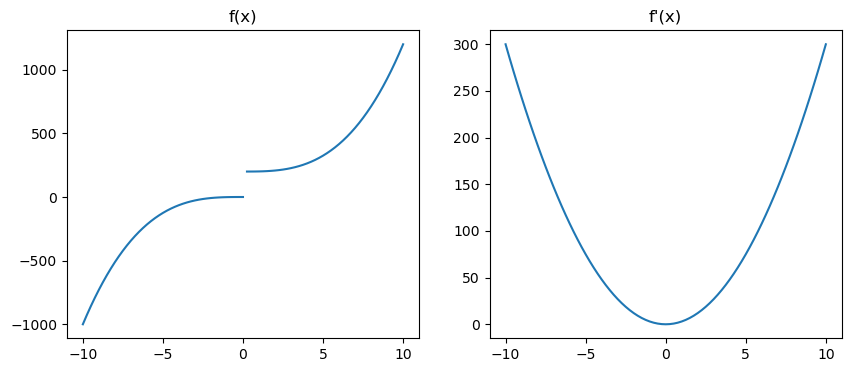

In [3]:
compute_f_and_df(my_jump_function)

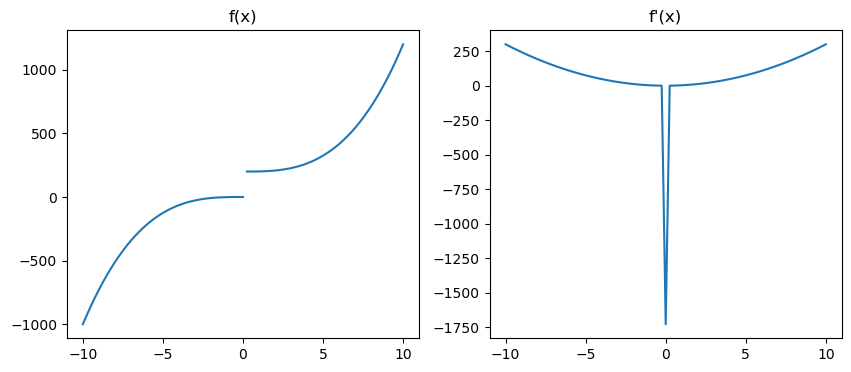

In [4]:
# Visualizing function where we define -1728 as derivative for x=0
compute_f_and_df(my_jump_function_2)

### 1.2 Inconsistent derivatives of a differentiable function.

Consider the (mathematical) function $g(x) = x^4$. Clearly, $g$ is differentiable everywhere.
- Implement $g$ as a DiffProg function in PyTorch so that PyTorch returns a derivative of $0$ at $\hat{x} = 0$.
- Implement $g$ again in DiffProg so that PyTorch now returns a derivative of $897$ at exactly the same point $\hat{x} = 0$.

The takeaway message of this exercise is that the data scientist must make sure the inputs to automatic differentiation are well-defined mathematically.

Hint: Use branches again. For the second function, use two branches $x = 0$ and $x \neq 0$.

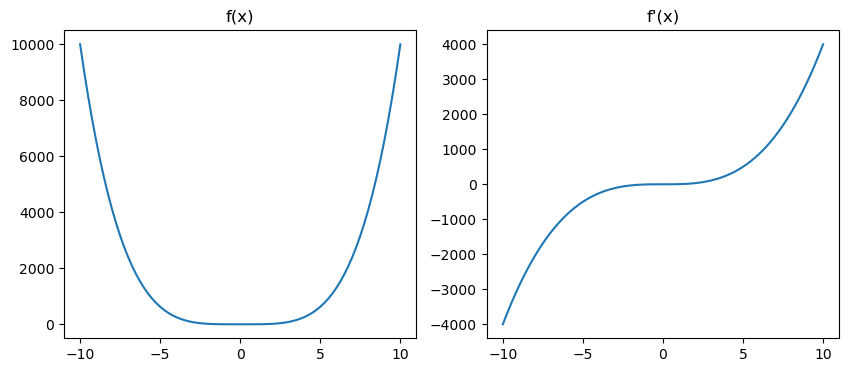

In [5]:
# Should return derivative of 0 at x=0
def g_1(x):
    return x**4

# Should return derivative of 897 at x=0
def g_2(x):
    if x==0:
        return 897*x
    else:
        return x**4

compute_f_and_df(g_1, jump=False)

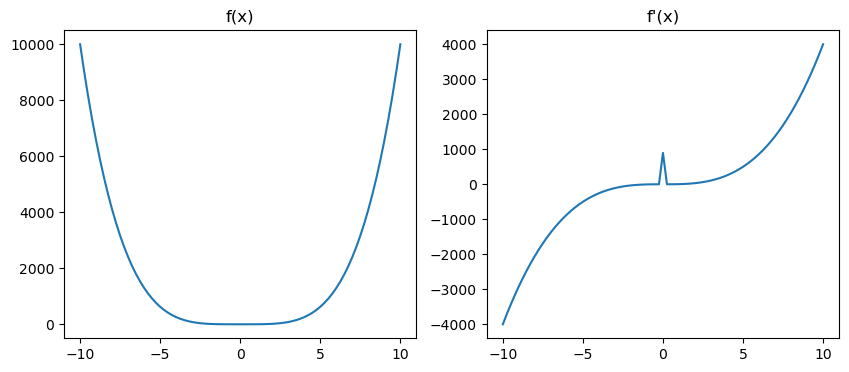

In [6]:
compute_f_and_df(g_2, jump=False)

### 1.3 Derivatives with loops: When is it valid?

In the lab, we defined a (mathematical) function $h(x, n) = \sum_{i=1}^{n} x^{n−1}$. We implemented this in DiffProg using a loop such that automatic differentiation gives us $∂ h(x, n)$ correctly. In this exercise, we will define $∂x$ a DiffProg function with a loop so that the underlying mathematical function is discontinuous.

- Write a DiffProg function in PyTorch which takes an input $x_0$ and iteratively updates $x_{t+1} \leftarrow x_t/2$ until a stopping criterion $|x_t| < 10^{−6}$ is satisfied.
- Plot this function in the range $[−2, 2]$. Are the derivatives of this function well-defined everywhere?
- Find a point $\hat{x}$ such that implementing the stopping criterion as $|x_t| < 10^{−6}$ or $|x_t| ≤ 10^{−6}$ changes the value of the derivative returned by PyTorch. Is the derivative mathematically well-defined at $\hat{x}$?
- Write out the (mathematical) function $ψ : \R → \R$ which is implemented by this DiffProg function.

The takeaway message of this part is that one must be careful when defining DiffProg functions with loops. The stopping criterion of the loop must not depend on the input which respect to which we compute a derivative.


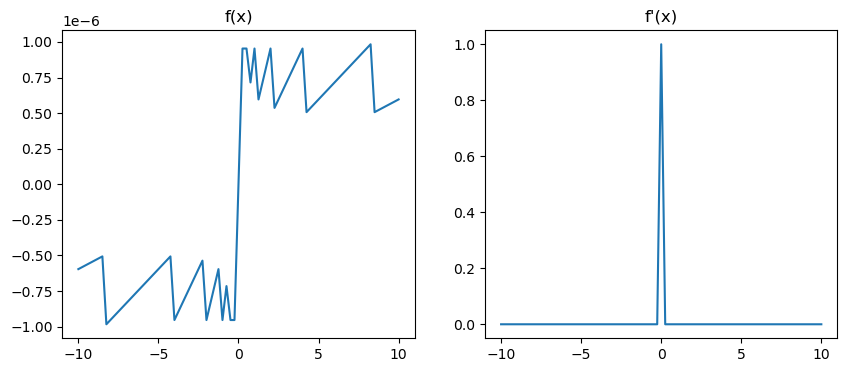

In [7]:
# Writing DiffProg function and plotting it for [-2,2]

def my_func_discontinuous(x0, condition='<'):
    if condition == '<':
        while torch.abs(x0) >= 1e-6:
            x0 = x0/2
    elif condition == '<=':
        while torch.abs(x0) > 1e-6:
            x0 = x0/2
    else:
        raise ValueError #"Must be < or <="
    return x0

compute_f_and_df(my_func_discontinuous, jump=False)

We see that in the range $[-2,2]$ the derivatives are not well defined as we see a lot of discontinuities at various points in the plot such as $x=±1$. There is also a jump discontinuity at x=0.

In [8]:
# Since we are changing the stopping condition, the derivative at the stopping condition is likely to vary
x = torch.tensor(1e-6, requires_grad=True)
y = my_func_discontinuous(x,condition='<')
grad = torch.autograd.grad(outputs=y, inputs=[x], allow_unused=True)[0]
print(x, grad, "(using < in terminating condition)")

y = my_func_discontinuous(x,condition='<=')
grad = torch.autograd.grad(outputs=y, inputs=[x], allow_unused=True)[0]
print(x, grad, "(using <= in terminating condition)")

tensor(1.0000e-06, requires_grad=True) tensor(0.5000) (using < in terminating condition)
tensor(1.0000e-06, requires_grad=True) tensor(1.) (using <= in terminating condition)


We see that our assumption is correct. We now plot the derivative at this point for both the conditions to see whether the derivative is well defined.

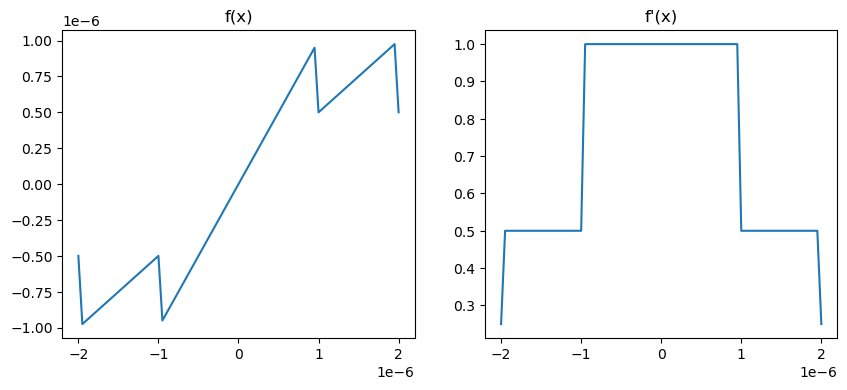

In [12]:
compute_f_and_df(my_func_discontinuous, jump=False, xs=torch.linspace(-2e-6,2e-6,81, requires_grad=True), condition='<')

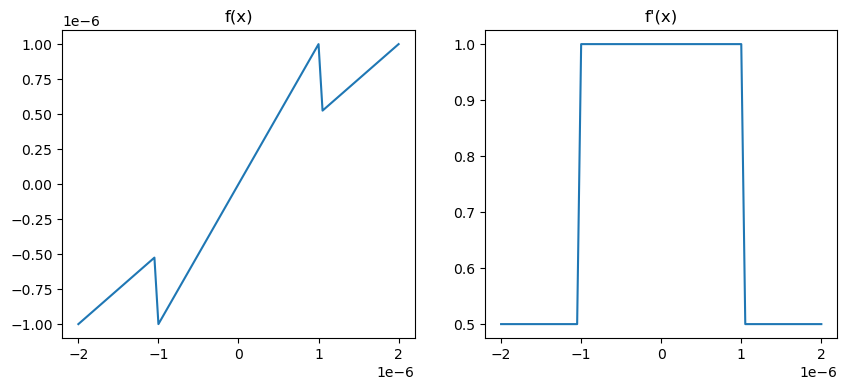

In [13]:
compute_f_and_df(my_func_discontinuous, jump=False, xs=torch.linspace(-2e-6,2e-6,81, requires_grad=True), condition='<=')

We see that the derivative is not well defined at |1e-6| as there is a jump between 0.5 and 1

The mathematical function implemented by this DiffProg function is as follows:

$$
f(x) = 
$$

### 1.4 When can we not use branches in differentiable programs?

Consider the mathematical function $\phi : \R → [0, 1]$ by
$$
\phi(x) = \begin{cases} 1 \text{ if } x \ge 0 \\
0 \text{ otherwise}

\end{cases}
$$
- Plot this function. Is it continuous? Is it differentiable almost everywhere?
- Implement this in PyTorch. Try to compute its derivatives. What do we get?
- Can we train a differentiable program containing this function as a component using stochastic gradient descent? Why or why not? Justify your answer in words.

**Note:** The classification accuracy of a binary classifier can be computed using the function φ. Why d o we use logistic regression to train a classifier and not use the classification accuracy directly?

*Solution:*

This function is continuous and differentiable almost everywhere, with the exception of $x = 0$ where we observe a jump discontinuity.

We plot it along with its derivative after implementing it as a DiffProg in PyTorch (in the interest of resuing code!)

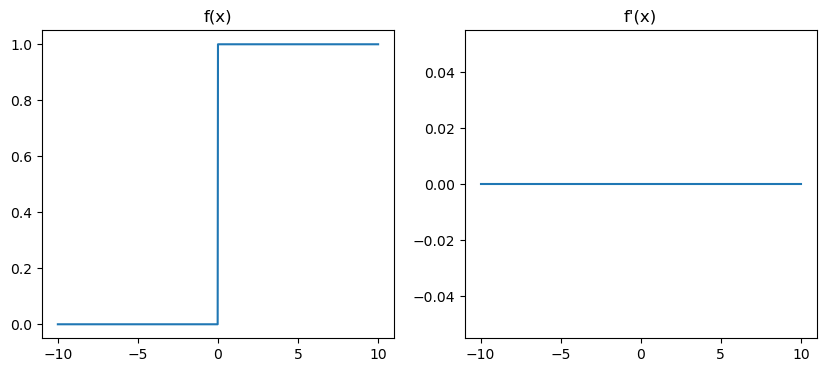

In [11]:
def my_func_0_1(x):
    if x >= 0:
        return torch.ones_like(x, requires_grad=True)
    else:
        return torch.zeros_like(x, requires_grad=True)

compute_f_and_df(my_func_0_1, jump=False, xs=torch.linspace(-10,10,1001,requires_grad=True))

We get a derivative of 0 over all ranges of values.

We cannot train a stochastic gradient descent model using this function as a component because this function has a gradient of 0. Due to this we will always have an update of value of 0 and stoachstic gradient descent will be unable to update the parameters.

## 2. Data Augmentation